In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers.legacy import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
EPOCHS = 6
INIT_LR = 0.005
BS = 128
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'PlantVillage'
width=256
height=256
depth=3

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___Late_blight ...
[INFO] Image loading completed


entering the files from root directory using the function defined in the previous cell 


In [5]:
image_size = len(image_list)
image_size

2000

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [7]:
n_classes

2

pickle.dump is a format to save data efficiently. 

In [8]:
print(label_binarizer.classes_)

['Potato___Early_blight' 'Potato___Late_blight']


In [9]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

divding RGB values (0-255) by 225 to scale (reason- so that it ranges from 0 - 1.2) 

In [10]:
np_image_list[0].shape

(256, 256, 3)

In [11]:
image_labels[1015]

array([1])

In [12]:
image_labels_2 = []
for i, j in enumerate(image_labels):
    here = np.zeros(n_classes, dtype=np.int64)
    here[j[0]] = 1
    image_labels_2.append(here) 

In [13]:
image_labels = np.array(image_labels_2)
image_labels.shape

(2000, 2)

In [14]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42, shuffle=True) 

[INFO] Spliting data to train, test


In [15]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

introducing noise to the image data so that it trains on human error

In [16]:
callback = EarlyStopping(monitor="val_loss", patience=2)

In [17]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(16, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.5))
#model.add(Conv2D(64, (3, 3), padding="same"))
#model.add(Activation("relu"))
#model.add(BatchNormalization(axis=chanDim))
#model.add(Conv2D(64, (5, 5), padding="same"))
#model.add(Activation("relu"))
#model.add(BatchNormalization(axis=chanDim))
#model.add(MaxPooling2D(pool_size=(5, 5)))
#model.add(Dropout(0.8))
#model.add(Conv2D(128, (3, 3), padding="same"))
#model.add(Activation("relu"))
#model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

conv2D - (convolution for a 2D matrix) X'lying w/ a 3x3 pixel on the complete image data 
relu - rectified linear unit - makes -ve value 0 and +ve remains as it is


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 activation (Activation)     (None, 256, 256, 16)      0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 85, 85, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 32)        4

In [19]:
opt = Adam(lr=INIT_LR)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


c:\Users\VARSHA\anaconda3\Lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/6
12/12 [==============================] - 76s 5s/step - loss: 0.2535 - accuracy: 0.9022 - val_loss: 0.6910 - val_accuracy: 0.5125
Epoch 2/6
12/12 [==============================] - 65s 6s/step - loss: 0.1235 - accuracy: 0.9511 - val_loss: 2.2466 - val_accuracy: 0.5025
Epoch 3/6
12/12 [==============================] - 62s 5s/step - loss: 0.1086 - accuracy: 0.9565 - val_loss: 3.9954 - val_accuracy: 0.5025
Epoch 4/6
12/12 [==============================] - 58s 5s/step - loss: 0.0894 - accuracy: 0.9654 - val_loss: 33.9038 - val_accuracy: 0.5025
Epoch 5/6
12/12 [==============================] - 55s 5s/step - loss: 0.0978 - accuracy: 0.9640 - val_loss: 7.5740 - val_accuracy: 0.5025
Epoch 6/6
12/12 [==============================] - 56s 5s/step - loss: 0.1100 - accuracy: 0.9606 - val_loss: 2.1150 - val_accuracy: 0.5050


In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
13/13 [==============================] - 3s 229ms/step - loss: 2.1150 - accuracy: 0.5050
Test Accuracy: 50.49999952316284


In [23]:
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...


In [24]:
#loaded_model = pickle.load(open('cnn_model.pkl', 'rb'))

In [25]:
#loaded_model = pickle.load(open('path/cnn_model.pkl', 'rb'))

In [26]:
print(x_test[25:26].shape)
print(y_test[25])

(1, 256, 256, 3)
[1 0]


In [27]:
res = model.predict(x_test[25:26])

1/1 [==============================] - 0s 475ms/step


In [28]:
print(res[0])

[0.00148116 0.9985189 ]


In [46]:
from PIL import Image

# Load and preprocess the image
image_dir = r"C:/Users/VARSHA/.vscode/PlantVillage/potato/Potato___Late_blight/0e7f0484-16eb-4183-b702-0a5b4f94d015___RS_LB 4000.JPG"

# Replace potential null bytes with spaces or remove them
image_dir = image_dir.replace('/x00', '').strip()

# Load the image using PIL
image = Image.open(image_dir)

# Resize the image to match your expected input shape
image = image.resize((width, height))

# Convert the image to a numpy array and normalize pixel values
image = np.array(image)
image = image.astype('float32') / 255.0

# Verify the shape of the preprocessed image
print(image.shape)

# Check the model's expected input shape
expected_input_shape = model.input_shape[1:]

if image.shape == expected_input_shape:
    print("Image shape matches the expected input shape of the model.")
else:
    print("Image shape does not match the expected input shape of the model.")

# Expand dimensions if needed and make predictions
image = np.expand_dims(image, axis=0)  # Add a batch dimension if required
result = model.predict(image)
print(result)


(256, 256, 3)
Image shape matches the expected input shape of the model.
1/1 [==============================] - 0s 438ms/step
[[0. 1.]]


In [30]:
im.shape

(0,)

probability:1.0
Potato___Late_blight


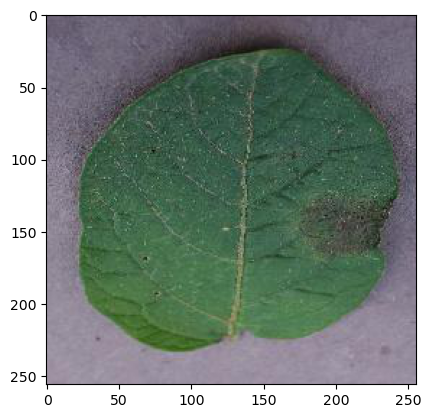

In [48]:
import matplotlib.image as img 
this_image = img.imread(image_dir)
plt.imshow(this_image)
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])